In [84]:
library("ggplot2")

# https://theoreticalecology.wordpress.com/2010/09/17/metropolis-hastings-mcmc-in-r/


The downloaded binary packages are in
	/var/folders/yd/s2tbldys49q1qq6bv1skfs340000gn/T//RtmpHC2FvJ/downloaded_packages


In [85]:
#options(repr.plot.width=4, repr.plot.height=3)


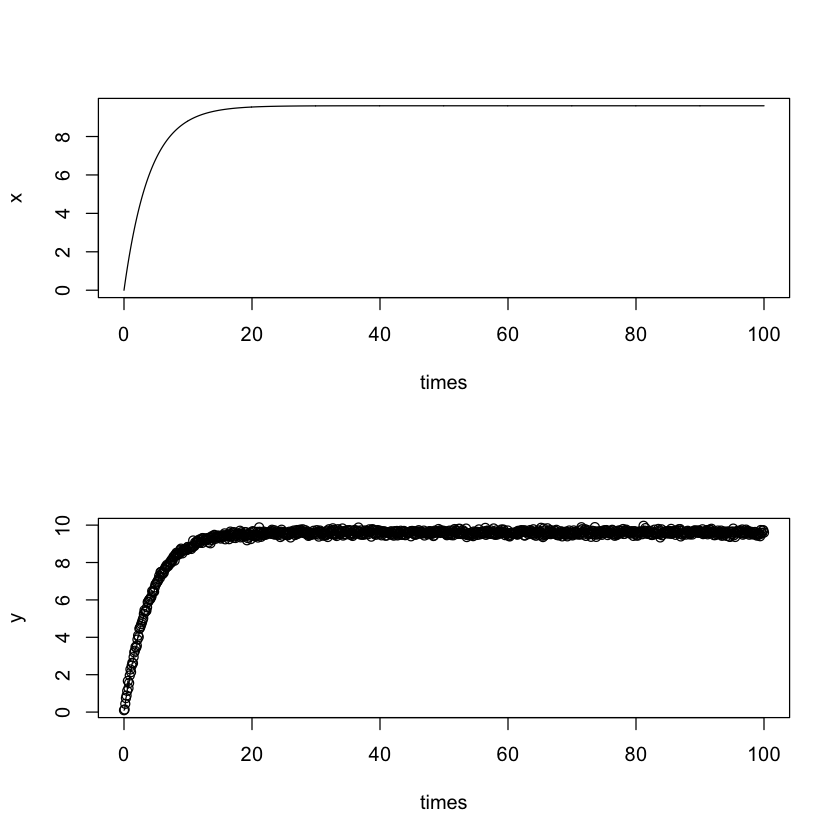

In [72]:
# solution to first-order kinetics

NSample = 1000
sigma <- 0.1 # observation noise

# parametrize by kon and koff

kon <- 2.4
koff <- 0.25

times <- seq(from=0,to=100,by=100/(NSample-1))
x <- kon/koff*(1-exp(-koff*times))
soln <- data.frame( "x"=x, "times"=times)

# add noise
soln$observations = x + rnorm(NSample,0,sigma)

par(mfrow = c(2,1))

plot(x~times,data=soln,type='l')
plot(y~times,data=soln,type='o')


In [73]:
# define the likelihood function

logLikelihood <- function(param,times,y){
    kon = param[1]
    koff = param[2]
    sigma = param[3]
    
    pred = kon/koff*(1-exp(-koff*times))

    singleLikelihoods = dnorm(y, mean=pred, sd=sigma, log=T) # really the log likelihood
    sumLikelihood = sum(singleLikelihoods) # really the log of the product of likelihoods
        
    return(sumLikelihood)
    
}

# Test it out
logLikelihood(c(2.3, 0.25, 0.1),times,y)
logLikelihood(c(2.5, 0.25, 0.1),times,y)

[1] -6604.892

[1] -6647.231

In [74]:
######## Metropolis algorithm ################

proposalGenerator <- function(currentParam){
    
    proposalParam = rnorm(3, mean=currentParam, sd = c(0.002,0.0002,0.0001)) 
    # play with these to make the acceptance rates around 30% for most efficient MCMC
    proposalParam[proposalParam<0] <- 0 # Prevent negative values
    return(proposalParam)
}

run_metropolis_MCMC <- function(startvalue, iterations){
    chain = array(dim = c(iterations+1,3))
    chain[1,] = startvalue
    for (i in 1:iterations){
        
        proposal = proposalGenerator(chain[i,])
         
        # This is the Metropolis-Hastings ("Boltzmann") test
        probab = exp(logLikelihood(proposal,times,y) - logLikelihood(chain[i,],times,y))    
        if (runif(1) < probab){
            chain[i+1,] = proposal
        }
        else{
            chain[i+1,] = chain[i,]
        }
    }
    return(chain)
}
 
startvalue = c(1,0.1,0.1)
chain = run_metropolis_MCMC(startvalue, 100000)
 
burnIn = 10000
acceptance = 1-mean(duplicated(chain[-(1:burnIn),]))

1,0.1,0.1
1,0.1,0.1
1,0.1,0.1
1,0.1,0.1
1,0.1,0.1
1,0.1,0.1


[1] 0.3338281


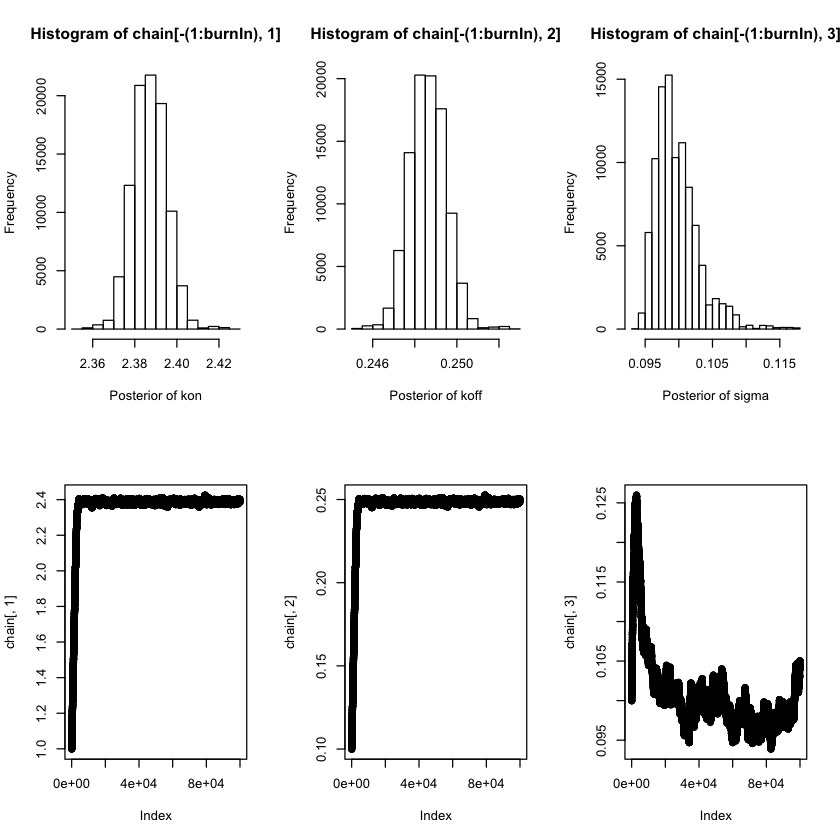

In [76]:
head(chain)
print(acceptance) # Is it close to 30%?

# Conditional posteriors
par(mfrow = c(2,3))

hist(chain[-(1:burnIn),1], xlab="Posterior of kon")
hist(chain[-(1:burnIn),2], xlab="Posterior of koff")
hist(chain[-(1:burnIn),3], xlab="Posterior of sigma")

plot(chain[,1])
plot(chain[,2])
plot(chain[,3])

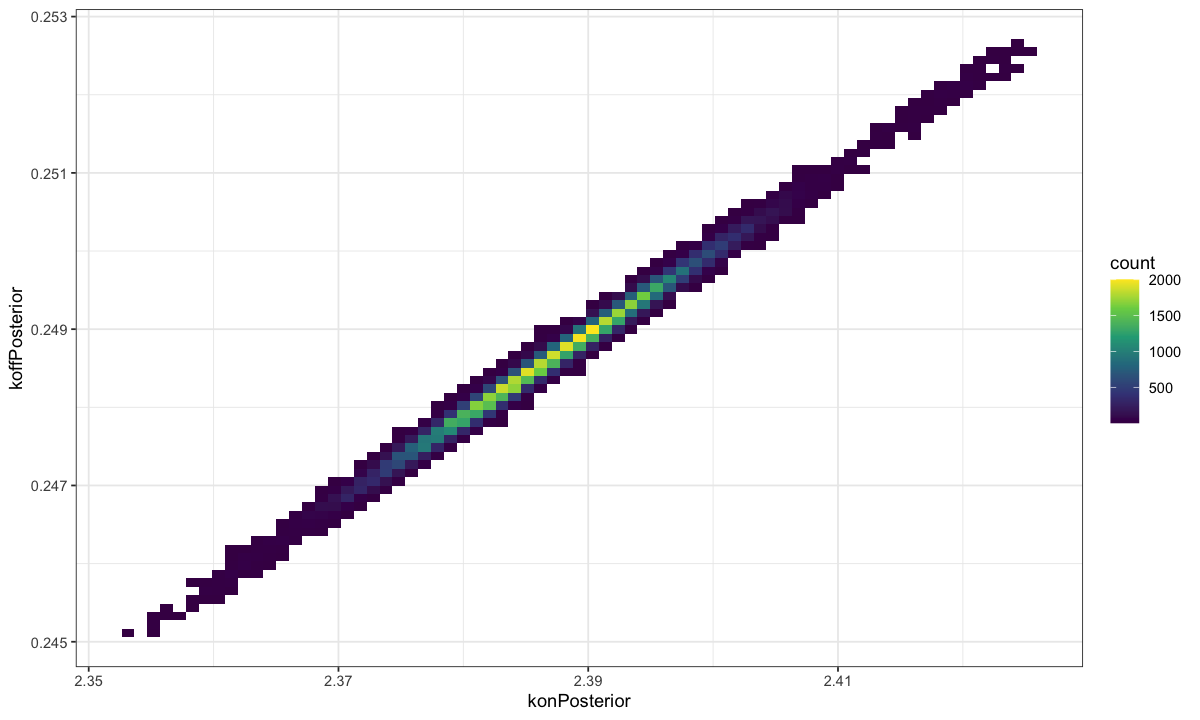

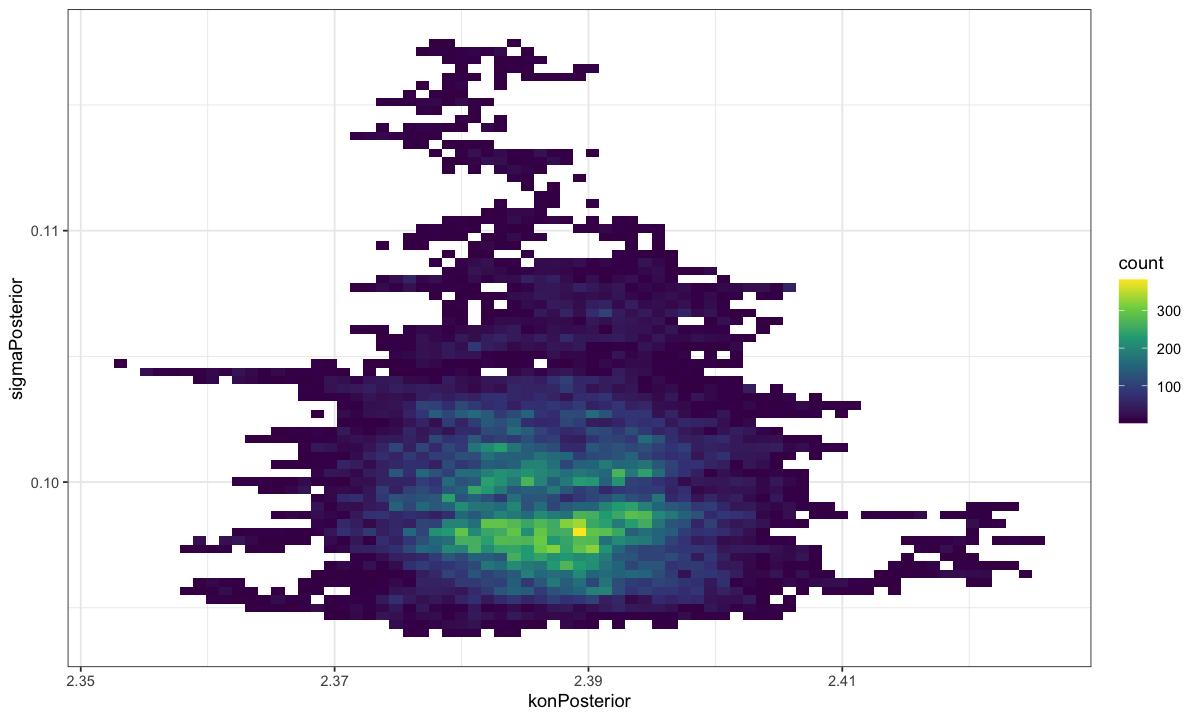

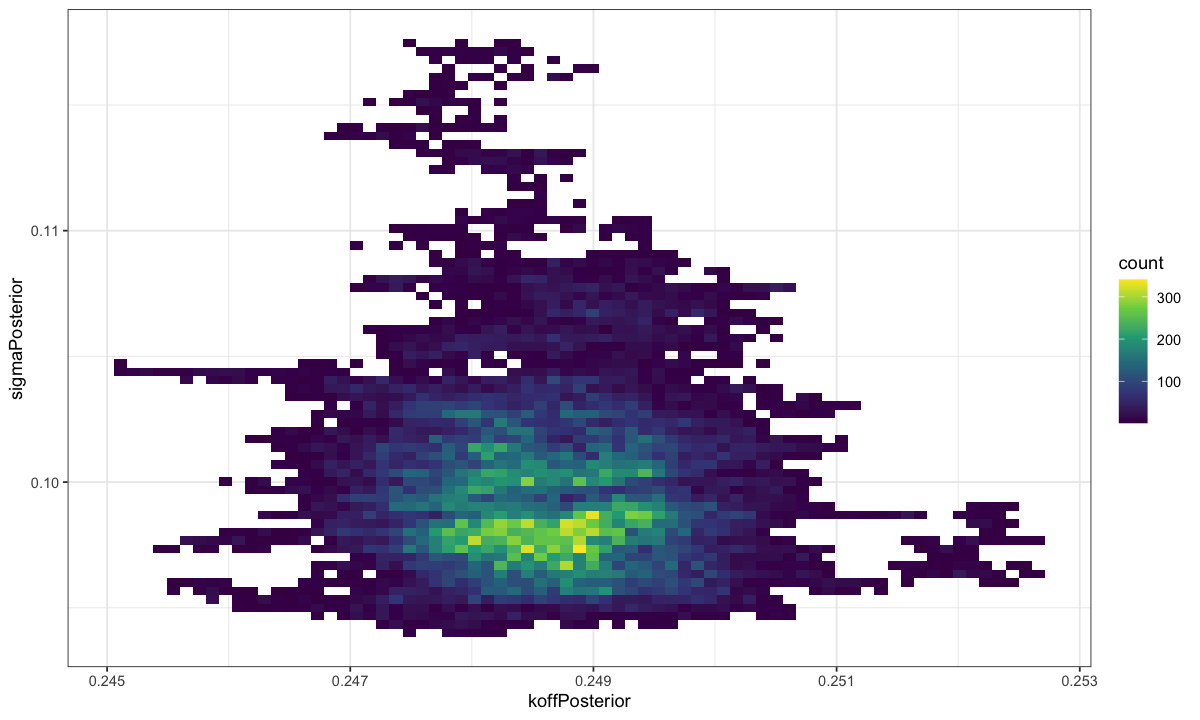

In [89]:
# joint posterior

dfChain <- data.frame(konPosterior=chain[-(1:burnIn),1], 
                      koffPosterior=chain[-(1:burnIn),2],
                      sigmaPosterior=chain[-(1:burnIn),3] )


ggplot(dfChain, aes(x=konPosterior, y=koffPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()

ggplot(dfChain, aes(x=konPosterior, y=sigmaPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()

ggplot(dfChain, aes(x=koffPosterior, y=sigmaPosterior) ) +
  geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()



